# Import all necessary libraries

In [44]:
pip install numpy scipy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [45]:
import warnings
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.parsing.preprocessing import preprocess_string
from gensim import corpora
from gensim.models import LdaModel
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import percentileofscore
from nltk import pos_tag
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.classify import NaiveBayesClassifier
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from nltk.probability import FreqDist
import random
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
warnings.filterwarnings("ignore")
from tabulate import tabulate

# Summary

## In this Jupyter notebook, we will explore the implementation of a recommendation system using content-based filtering techniques. Recommendation systems are crucial in today's digital landscape, facilitating personalized suggestions to users based on their preferences and behavior. Content-based filtering is one of the popular approaches to recommendation systems, where recommendations are made based on the similarity between items' attributes and the user's preferences. In our case, we will leverage the ratings and reviews from our dataset to build a content-based recommendation system for TV shows.

## Content-based filtering relies on the characteristics or attributes of items to recommend similar items to users. In our scenario, each TV show is represented by its ratings and reviews, which serve as the attributes. By analyzing the content of the reviews and ratings, we can identify patterns and similarities between different shows. When a user expresses interest in a particular show, our recommendation system will suggest other shows that share similar attributes or themes, based on the content analysis.

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Read the file involving Audience reviews and shows (ModifiedAudience.csv)

In [4]:
modified_audience_df = pd.read_csv("D:/Spring 2024 notes/Social Media Analytics/SMA_Project/ModifiedAudience.csv")
print(modified_audience_df)

       Unnamed: 0                            Show  Rating  \
0               0                            Loot     2.5   
1               1                            Loot     4.5   
2               2                            Loot     0.5   
3               3                            Loot     4.5   
4               4                            Loot     0.5   
...           ...                             ...     ...   
93190       93190  Once Upon a Time in Wonderland     5.0   
93191       93191  Once Upon a Time in Wonderland     2.5   
93192       93192  Once Upon a Time in Wonderland     2.0   
93193       93193  Once Upon a Time in Wonderland     5.0   
93194       93194  Once Upon a Time in Wonderland     5.0   

                                                  Review    Network  \
0      I love the stars, but the show is riddled with...  Apple TV+   
1      Great show to watch. It's something that's eas...  Apple TV+   
2      Another Apple tanker crashes into the reef wit.

In [5]:
max_reviews_per_show = 50
subset_df = modified_audience_df.groupby('Show').apply(lambda x: x.head(min(len(x), max_reviews_per_show))).reset_index(drop=True)

print(subset_df.tail(30))

       Unnamed: 0           Show  Rating  \
17164       76255  Young Justice     1.0   
17165       76256  Young Justice     2.5   
17166       76257  Young Justice     4.0   
17167       76258  Young Justice     0.5   
17168       76259  Young Justice     3.5   
17169       76260  Young Justice     0.5   
17170       76261  Young Justice     0.5   
17171       76262  Young Justice     0.5   
17172       76263  Young Justice     0.5   
17173       76264  Young Justice     1.0   
17174       76265  Young Justice     3.5   
17175       76266  Young Justice     5.0   
17176       76267  Young Justice     5.0   
17177       76268  Young Justice     0.5   
17178       76269  Young Justice     0.5   
17179       76270  Young Justice     5.0   
17180        7363        Younger     1.5   
17181        7364        Younger     4.5   
17182        7365        Younger     5.0   
17183        7366        Younger     3.0   
17184        7367        Younger     1.5   
17185        7368        Younger

In [6]:
subset_df.shape

(17194, 8)

## Recommendation system.

In [23]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(subset_df['Review'].fillna(''))
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

def weighted_cosine_similarity(tfidf_matrix, ratings, alpha=0.5):
    normalized_ratings = (ratings - ratings.min()) / (ratings.max() - ratings.min())
    weighted_tfidf_matrix = tfidf_matrix.multiply(normalized_ratings[:, np.newaxis])
    weighted_cosine_sim = cosine_similarity(weighted_tfidf_matrix, weighted_tfidf_matrix)
    weighted_cosine_sim = alpha * weighted_cosine_sim + (1 - alpha) * cosine_similarity(tfidf_matrix, tfidf_matrix)
    return weighted_cosine_sim

weighted_cosine_sim = weighted_cosine_similarity(tfidf_matrix, subset_df['Rating'])

def get_top_similar_shows_for_all(weighted_cosine_sim_matrix, shows, n=5):
    similar_shows_dict = {}
    for show_name in shows:
        indices = subset_df[subset_df['Show'] == show_name].index
        if len(indices) == 0:
            continue 
        idx = indices[0]
        sim_scores = list(enumerate(weighted_cosine_sim_matrix[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:n+1]
        similar_shows = [subset_df.iloc[i]['Show'] for i, _ in sim_scores if subset_df.iloc[i]['Show'] != show_name]
        similar_shows_dict[show_name] = similar_shows
    return similar_shows_dict

top_similar_shows_dict = get_top_similar_shows_for_all(weighted_cosine_sim, subset_df['Show'].unique())
for show, similar_shows in top_similar_shows_dict.items():
    num_similar_shows = len(similar_shows)
    print(f"Show: {show}")
    print(f"Number of Similar Shows: {num_similar_shows}")
    print("Similar Shows:")
    for similar_show in set(similar_shows):
        print(f"- {similar_show}")
    print()

Show: 11.22.63
Number of Similar Shows: 5
Similar Shows:
- The Last Man on Earth
- The Man Who Fell to Earth
- Justified
- Alias Grace
- Batwoman

Show: 13 Reasons Why
Number of Similar Shows: 5
Similar Shows:
- Marvel's Agents of S.H.I.E.L.D.
- Arrested Development
- Better Call Saul
- The OA
- Brooklyn Nine-Nine

Show: 1883
Number of Similar Shows: 5
Similar Shows:
- Doom Patrol
- Downton Abbey on Masterpiece
- Joe vs Carole
- Band of Brothers
- Marvel's The Punisher

Show: 1971: The Year That Music Changed Everything
Number of Similar Shows: 2
Similar Shows:
- Adventure Time

Show: 24
Number of Similar Shows: 2
Similar Shows:
- Adventure Time

Show: 30 Coins
Number of Similar Shows: 5
Similar Shows:
- Rise
- The X-Files
- Sweet Tooth
- Mindhunter
- Peaky Blinders

Show: 30 Rock
Number of Similar Shows: 5
Similar Shows:
- The Wire
- Suits
- Young Justice
- Band of Brothers

Show: A Little Late With Lilly Singh
Number of Similar Shows: 4
Similar Shows:
- The Nevers
- Little Fires Ever

# Performance Analysis. 

In [41]:
subset_shows = ['24', 'Loot', '30 Rock', 'A Teacher', 'Acapulco', 'After Life', 'Adventure Time', 'Alias', 'Alias Grace', 'Altered Carbon', 'Amphibia']
predicted_ratings = [predict_ratings(show, weighted_cosine_sim, subset_df['Rating']) for show in subset_shows]
actual_ratings = [subset_df.loc[subset_df['Show'] == show]['Rating'].values[0] for show in subset_shows]

mse_subset = mean_squared_error(actual_ratings, predicted_ratings)
print(f"Mean Squared Error (MSE) for subset of shows: {mse_subset}")

for i, show in enumerate(subset_shows):
    print(f"Show: {show}")
    print(f"Predicted Rating: {predicted_ratings[i]}")
    print(f"Actual Rating: {actual_ratings[i]}")
    print()

Mean Squared Error (MSE) for subset of shows: 1.4963636363636363
Show: 24
Predicted Rating: 4.5
Actual Rating: 4.0

Show: Loot
Predicted Rating: 4.8
Actual Rating: 2.5

Show: 30 Rock
Predicted Rating: 5.0
Actual Rating: 5.0

Show: A Teacher
Predicted Rating: 4.0
Actual Rating: 4.0

Show: Acapulco
Predicted Rating: 4.7
Actual Rating: 5.0

Show: After Life
Predicted Rating: 4.3
Actual Rating: 4.0

Show: Adventure Time
Predicted Rating: 4.8
Actual Rating: 5.0

Show: Alias
Predicted Rating: 5.0
Actual Rating: 4.5

Show: Alias Grace
Predicted Rating: 4.7
Actual Rating: 3.5

Show: Altered Carbon
Predicted Rating: 4.9
Actual Rating: 5.0

Show: Amphibia
Predicted Rating: 4.5
Actual Rating: 1.5



# Visualizations

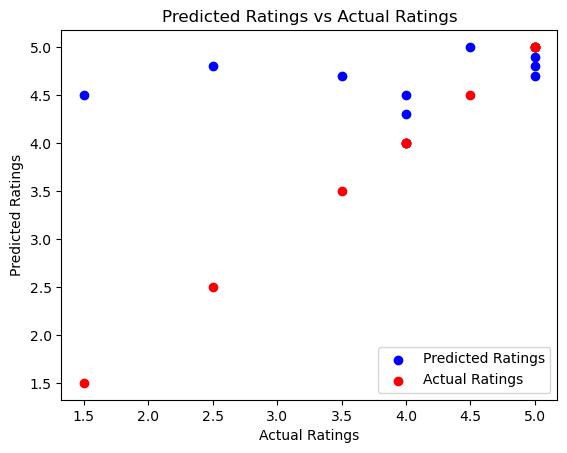

In [43]:
plt.scatter(actual_ratings, predicted_ratings, color='blue', label='Predicted Ratings')
plt.scatter(actual_ratings, actual_ratings, color='red', label='Actual Ratings')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Predicted Ratings vs Actual Ratings')
plt.legend()
plt.show()

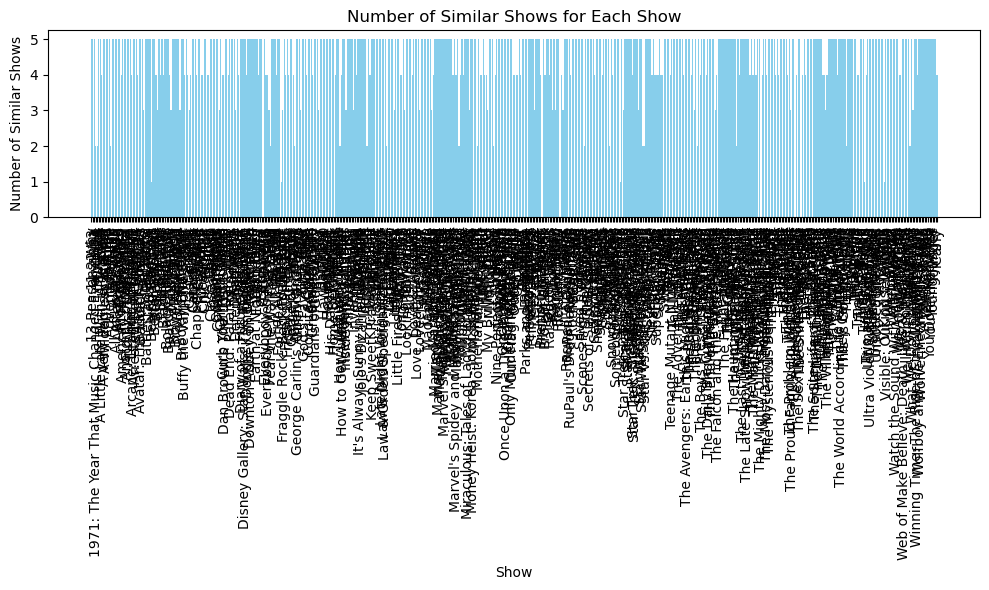

In [19]:
plt.figure(figsize=(10, 6))
df_similarity['Num_Similar_Shows'] = df_similarity['Similar Shows'].apply(len)
plt.bar(df_similarity['Show'], df_similarity['Num_Similar_Shows'], color='skyblue')
plt.xlabel('Show')
plt.ylabel('Number of Similar Shows')
plt.title('Number of Similar Shows for Each Show')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

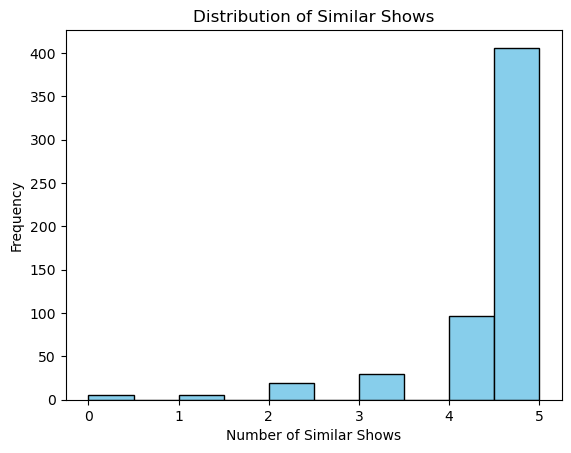

In [27]:
num_similar_shows_values = [len(similar_shows) for similar_shows in top_similar_shows_dict.values()]
plt.hist(num_similar_shows_values, bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Number of Similar Shows')
plt.ylabel('Frequency')
plt.title('Distribution of Similar Shows')
plt.show()

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------